In [2]:
!pip install trimesh

  Using cached trimesh-4.5.3-py3-none-any.whl.metadata (18 kB)
Using cached trimesh-4.5.3-py3-none-any.whl (704 kB)



File saved at: E:\OneDrive\JSU\02 Areas\02 Research\Austin Downey\contoured_surface.obj


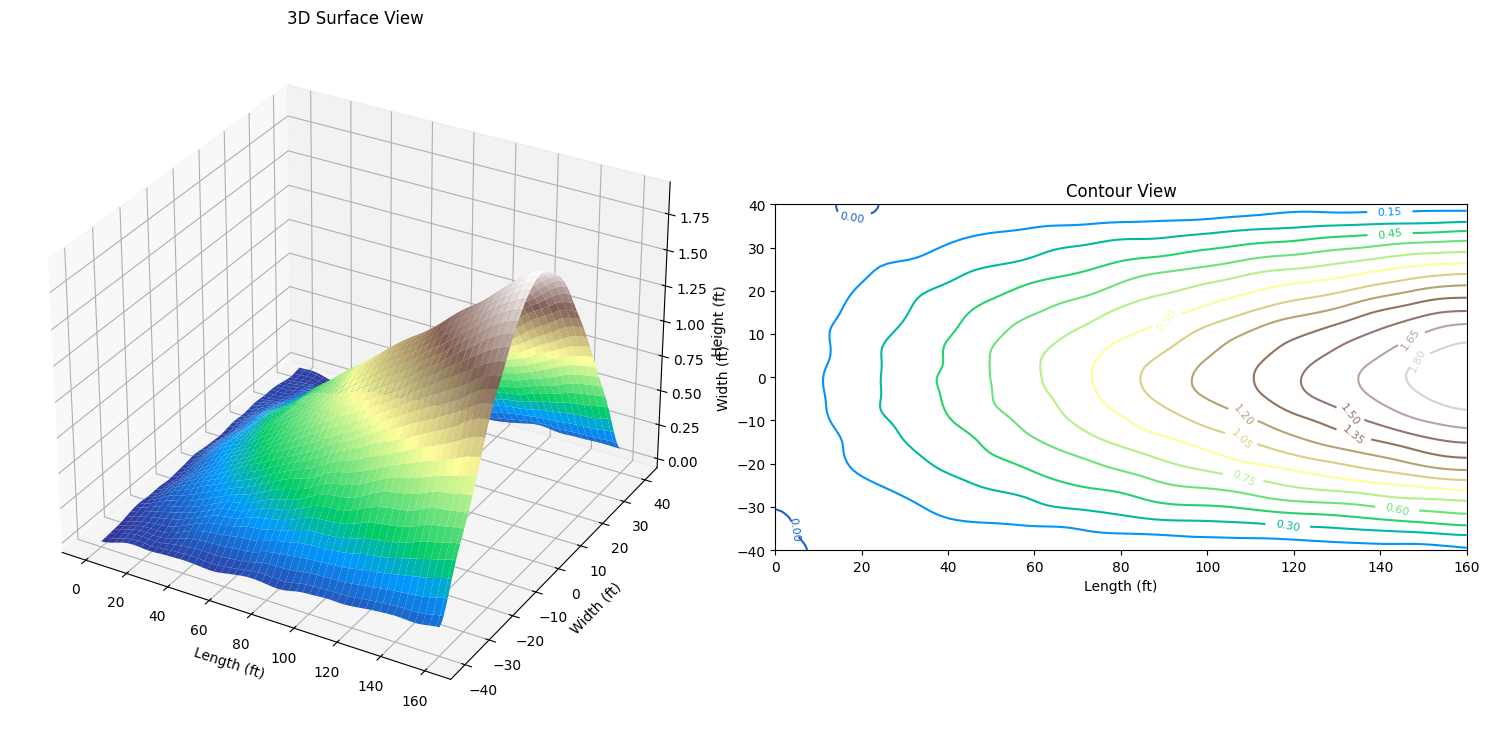

In [3]:
#create Configurable Surface and export into *.obj format
import numpy as np
import trimesh
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

def create_contoured_surface(length=160, width=80, max_height=2.0, resolution=100):
    """
    Create a surface with natural-looking contours.
    
    Parameters:
    -----------
    length : float
        Length of the surface (in feet)
    width : float
        Width of the surface (in feet)
    max_height : float
        Maximum height of the surface
    resolution : int
        Number of points along each dimension
    """
    # Create coordinate grids
    x = np.linspace(0, length, resolution)
    y = np.linspace(-width/2, width/2, resolution)
    X, Y = np.meshgrid(x, y)
    
    # Create base elevation using a combination of gradual slopes
    # This creates a more natural looking surface
    Z = np.zeros_like(X)
    
    # Create main slope along length
    slope_factor = max_height / length
    for i in range(resolution):
        base_height = X[0, i] * slope_factor
        
        # Add variation to each cross section
        for j in range(resolution):
            # Calculate distance from centerline
            dist_from_center = abs(Y[j, i]) / (width/2)
            
            # Create natural-looking cross-sectional profile
            edge_factor = 1 - (dist_from_center ** 1.5)  # Softer edges
            
            # Combine longitudinal slope with cross-sectional profile
            Z[j, i] = base_height * edge_factor
    
    # Add some natural variation
    noise = np.random.normal(0, 0.05, Z.shape)
    Z += noise * max_height
    
    # Smooth the surface to create more natural contours
    Z = gaussian_filter(Z, sigma=3)
    
    # Create vertices array
    vertices = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
    
    # Create faces (triangles)
    faces = []
    for i in range(resolution-1):
        for j in range(resolution-1):
            vertex = i * resolution + j
            faces.append([vertex, vertex+1, vertex+resolution])
            faces.append([vertex+1, vertex+resolution+1, vertex+resolution])
    
    # Create the mesh
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    return mesh, X, Y, Z

def save_and_show_surface(mesh, X, Y, Z, filename="contoured_surface.obj"):
    """
    Save the surface mesh and show visualization with contour lines.
    """
    # Get the current working directory and create full path
    current_dir = os.getcwd()
    full_path = os.path.join(current_dir, filename)
    
    # Save the mesh
    mesh.export(full_path)
    print(f"\nFile saved at: {full_path}")
    
    # Create visualization
    fig = plt.figure(figsize=(15, 10))
    
    # 3D Surface plot
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(X, Y, Z, cmap='terrain', edgecolor='none')
    ax1.set_xlabel('Length (ft)')
    ax1.set_ylabel('Width (ft)')
    ax1.set_zlabel('Height (ft)')
    ax1.set_title('3D Surface View')
    
    # Contour plot
    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, levels=15, cmap='terrain')
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.set_xlabel('Length (ft)')
    ax2.set_ylabel('Width (ft)')
    ax2.set_title('Contour View')
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Create the contoured surface
    surface, X, Y, Z = create_contoured_surface(
        length=160,      # 160 feet length
        width=80,        # 80 feet width
        max_height=2.0,  # 2 feet maximum height
        resolution=300   # 100x100 grid points
    )
    
    # Save and show the surface
    save_and_show_surface(surface, X, Y, Z)


File saved at: E:\OneDrive\JSU\02 Areas\02 Research\Austin Downey\terrain_surface.obj


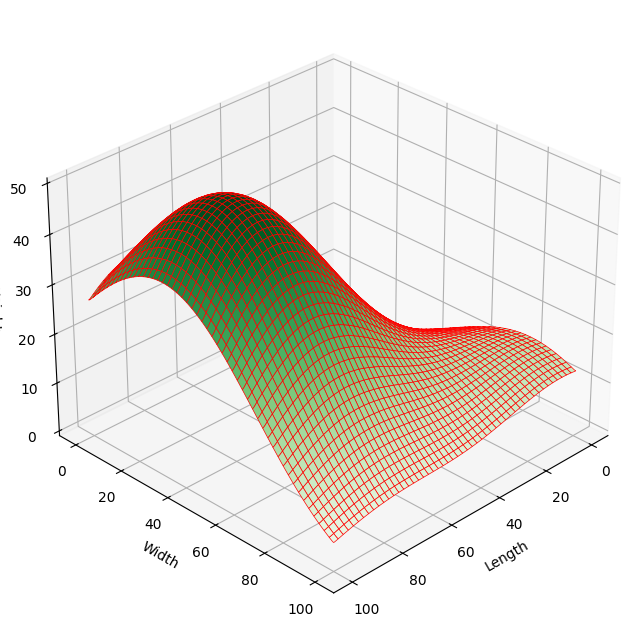

In [26]:
#Configurable Surface with nature like terrain and export into *.obj format
import numpy as np
import trimesh
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from matplotlib.path import Path

class TerrainSurface:
    def __init__(self, params=None):
        # Default parameters
        self.default_params = {
            # Basic dimensions
            'length': 100,          # Length of the surface
            'width': 60,            # Width of the surface
            'resolution': 400,      # Grid resolution
            'max_height': 10.0,      # Maximum height of the surface
            
            # Surface characteristics
            'base_height': 1.0,     # Base height of the surface
            'height_variation': 0.5, # How much height varies from base
            'smoothness': 1.0,      # Smoothness factor (higher = smoother)
            
            # Terrain features
            'n_hills': 3,           # Number of major elevation changes
            'hill_size': 20,        # Size of elevation features
            'hill_height': 0.5,     # Height of elevation features
            
            # Visualization
            'cmap': 'Greens',       # Color map for visualization
            'contour_color': 'red', # Color of contour lines
            'contour_width': 0.5,   # Width of contour lines
            'view_angle': (30, 45)  # (elevation, azimuth) for 3D view
        }
        
        # Update with provided parameters
        self.params = self.default_params.copy()
        if params:
            self.params.update(params)

    def generate_surface(self):
        """Generate the terrain surface based on parameters"""
        # Create coordinate grid
        x = np.linspace(0, self.params['length'], self.params['resolution'])
        y = np.linspace(0, self.params['width'], self.params['resolution'])
        self.X, self.Y = np.meshgrid(x, y)
        
        # Initialize height map
        self.Z = np.ones_like(self.X) * self.params['base_height']
        
        # Add major elevation features (hills)
        for _ in range(self.params['n_hills']):
            # Random position for each hill
            cx = np.random.uniform(0, self.params['length'])
            cy = np.random.uniform(0, self.params['width'])
            
            # Create gaussian hill
            hill = self.params['hill_height'] * np.exp(
                -((self.X - cx)**2 + (self.Y - cy)**2) / 
                (2 * self.params['hill_size']**2)
            )
            self.Z += hill
        
        # Normalize height to desired range
        self.Z = (self.Z - self.Z.min()) / (self.Z.max() - self.Z.min())
        self.Z = self.Z * self.params['height_variation'] + self.params['base_height']
        
        # Apply smoothing
        self.Z = gaussian_filter(self.Z, sigma=self.params['smoothness'])
        
        # Create mesh
        vertices = np.column_stack((self.X.flatten(), self.Y.flatten(), self.Z.flatten()))
        
        # Create faces
        faces = []
        res = self.params['resolution']
        for i in range(res-1):
            for j in range(res-1):
                vertex = i * res + j
                faces.append([vertex, vertex+1, vertex+res])
                faces.append([vertex+1, vertex+res+1, vertex+res])
        
        self.mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        return self.mesh

    def save_and_show(self, filename="terrain_surface.obj"):
        """Save the mesh and show visualization"""
        # Save mesh
        current_dir = os.getcwd()
        full_path = os.path.join(current_dir, filename)
        self.mesh.export(full_path)
        print(f"\nFile saved at: {full_path}")
        
        # Create visualization
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot surface
        surf = ax.plot_surface(self.X, self.Y, self.Z,
                             cmap=self.params['cmap'],
                             edgecolor=self.params['contour_color'],
                             linewidth=self.params['contour_width'])
        
        # Set view angle
        ax.view_init(elev=self.params['view_angle'][0], 
                    azim=self.params['view_angle'][1])
        
        # Set labels
        ax.set_xlabel('Length')
        ax.set_ylabel('Width')
        ax.set_zlabel('Height')
        
        plt.show()

# Example usage
if __name__ == "__main__":
    # Define custom parameters (optional)
    params = {
        'length': 100,       
        'width': 100,        
        'max_height': 50,    
        'base_height': 0,    
        'height_variation': 50.0,  
        'smoothness': 2.0,   
        'n_hills': 5,        
        'hill_size': 30,     
        'hill_height': 15    
    }
    
    # Create and generate surface
    terrain = TerrainSurface(params)
    terrain.generate_surface()
    terrain.save_and_show()

In [16]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

class TerrainSurface:
    def __init__(self, params):
        self.params = params
    
    def generate_surface(self):
        # Generate a grid of points
        X, Y = np.meshgrid(np.linspace(-10, 10, self.params['resolution']),
                           np.linspace(-10, 10, self.params['resolution']))
        
        Z = np.zeros_like(X)
        
        # Add hills to the terrain
        for _ in range(self.params['n_hills']):
            hill_center_x = np.random.uniform(-10, 10)
            hill_center_y = np.random.uniform(-10, 10)
            hill_height = self.params['hill_height']
            hill_size = self.params['hill_size']
            
            distance_to_center = np.sqrt((X - hill_center_x)**2 + (Y - hill_center_y)**2)
            Z += hill_height * gaussian_filter(distance_to_center**(-self.params['smoothness']), sigma=hill_size)
        
        # Normalize the terrain height
        Z -= np.min(Z)
        Z /= np.max(Z) * self.params['max_height']
        
        return X, Y, Z
    
    def save_and_show(self, filename=None):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
       
        # Generate the surface if it hasn't been generated yet
        if not hasattr(self, 'X') or not hasattr(self, 'Y'):
            self.X, self.Y, self.Z = self.generate_surface()
        
        surf = ax.plot_surface(self.X, self.Y, self.Z,
                             cmap=self.params['cmap'],
                             edgecolor=self.params['contour_color'],
                             linewidth=self.params['contour_width'])
        
        ax.view_init(elev=self.params['view_angle'][0], 
                    azim=self.params['view_angle'][1])
        
        ax.set_xlabel('Length')
        ax.set_ylabel('Width')
        ax.set_zlabel('Height')
        
        plt.show()
       
       # Save the terrain as an OBJ file if a filename is provided
       if filename:
           self.save_to_obj(filename, self.X, self.Y, self.Z)
    
    def save_to_obj(self, filename, X, Y, Z):
        with open(filename, 'w') as f:
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    f.write(f"v {X[i, j]} {Y[i, j]} {Z[i, j]}\n")
            f.write("\n")
            for i in range(X.shape[0] - 1):
                for j in range(X.shape[1] - 1):
                    idx = i * X.shape[1] + j + 1
                    f.write(f"f {idx} {idx+1} {idx+X.shape[1]}\n")
                    f.write(f"f {idx+1} {idx+X.shape[1]} {idx+X.shape[1]+1}\n")

if __name__ == "__main__":
    # Define custom parameters (optional)
    params = {
        'resolution': 50,
        'n_hills': 3,
        'hill_height': 2,
        'hill_size': 4,
        'max_height': 10,
        'smoothness': 1.0,
        'cmap': 'viridis',
        'contour_color': 'black',
        'contour_width': 0.5,
        'view_angle': [30, -60]
    }
    
    # Number of terrains to generate
    num_terrains = 1
    
    for _ in range(num_terrains):
        terrain = TerrainSurface(params)
        
        # Show visualization and save as OBJ file
        filename = f"terrain_{_.}.obj"
        terrain.save_and_show(filename=filename)

IndentationError: unindent does not match any outer indentation level (<string>, line 55)